In [1]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"


# open3d visualization
import open3d as o3d
import PIL.Image as Image
import numpy as np
import cv2

from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
folder_path  = "/studio-storage1/datasets/objaverse_CPlabrender/objaverse-xl/scripts/rendering/results/renders_sketchfab_1-1000/00504e7f-a2f1-54b1-aff9-d0dc04094f04"

# Initialize lists to store the filenames
image_filenames = []
depth_filenames = []
normal_filenames = []
albedo_filenames = []
cam_param_filenames = []
depth_est_filenames = []

# Iterate over files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.exr'):
        depth_filenames.append(filename)
    elif filename.endswith('.npz'):
        cam_param_filenames.append(filename)
    elif 'normal' in filename:
        normal_filenames.append(filename)
    elif 'albedo' in filename:
        albedo_filenames.append(filename)
    elif 'depth' in filename:
        depth_est_filenames.append(filename)
    elif filename.endswith('.png'):
        image_filenames.append(filename)
        
    
# sorted everything
image_filenames.sort()
depth_filenames.sort()
normal_filenames.sort()
albedo_filenames.sort()
cam_param_filenames.sort()
depth_est_filenames.sort()


# Print the filenames
print("Image filenames:", sorted(image_filenames))
print("Depth filenames:", sorted(depth_filenames))
print("Normal filenames:", sorted(normal_filenames))
print("Albedo filenames:", sorted(albedo_filenames))
print("Camera parameter filenames:", sorted(cam_param_filenames))
print("Estimated depth filenames:", sorted(depth_est_filenames))

Image filenames: ['000.png', '001.png', '002.png', '003.png', '004.png', '005.png', '006.png', '007.png', '008.png', '009.png', '010.png', '011.png']
Depth filenames: ['000_depth0001.exr', '001_depth0001.exr', '002_depth0001.exr', '003_depth0001.exr', '004_depth0001.exr', '005_depth0001.exr', '006_depth0001.exr', '007_depth0001.exr', '008_depth0001.exr', '009_depth0001.exr', '010_depth0001.exr', '011_depth0001.exr']
Normal filenames: ['000_normal0001.png', '000_normalest512.png', '000_normalestDSINE.png', '001_normal0001.png', '001_normalest512.png', '001_normalestDSINE.png', '002_normal0001.png', '002_normalest512.png', '002_normalestDSINE.png', '003_normal0001.png', '003_normalest512.png', '003_normalestDSINE.png', '004_normal0001.png', '004_normalest512.png', '004_normalestDSINE.png', '005_normal0001.png', '005_normalest512.png', '005_normalestDSINE.png', '006_normal0001.png', '006_normalest512.png', '006_normalestDSINE.png', '007_normal0001.png', '007_normalest512.png', '007_normal

In [3]:

sample_id = 0

# read rgb using PIL

image = Image.open(os.path.join(folder_path, image_filenames[sample_id]))
image = np.array(image)

# read depth exr file
depth = cv2.imread(os.path.join(folder_path, depth_filenames[sample_id]),  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)  
depth[depth == 1e+10] = 0
depth_mask = depth > 0

depth_min = np.min(depth[depth_mask])
depth_max = np.max(depth[depth_mask])

depth_scaled = (depth - depth_min) / (depth_max - depth_min)
depth = depth[:,:,0]


# read normal png file
normal = Image.open(os.path.join(folder_path, normal_filenames[sample_id]))
normal = np.array(normal)

# read albedo png file
albedo = Image.open(os.path.join(folder_path, albedo_filenames[sample_id]))
albedo = np.array(albedo)

# read camera parameters
cam_params = np.load(os.path.join(folder_path, cam_param_filenames[sample_id]))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


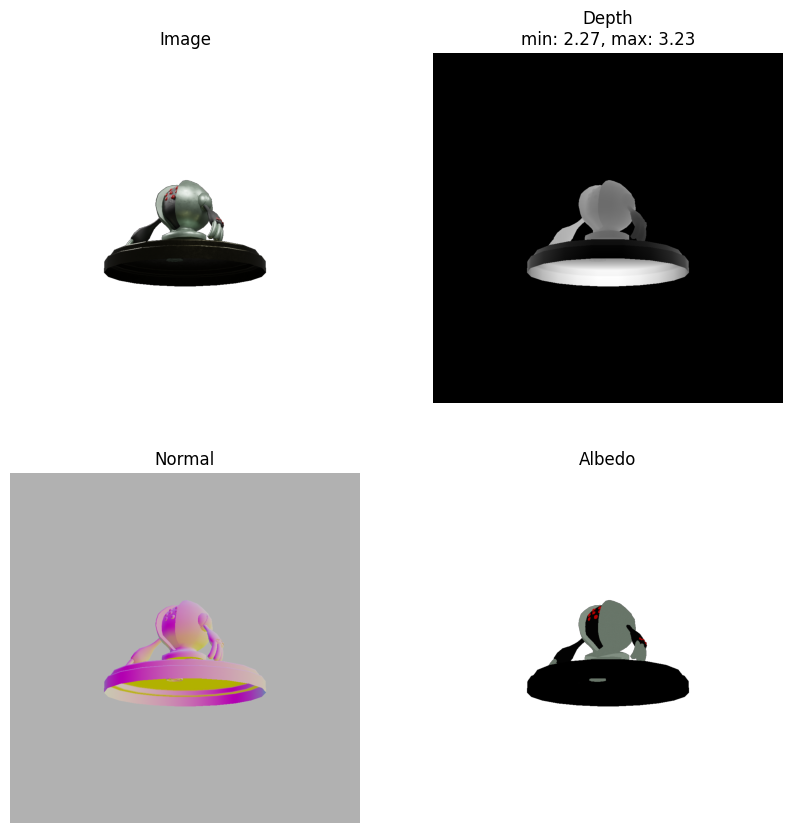

In [4]:
# visualize the images
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title('Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(depth_scaled)
# print depth min max on the title
ax[0, 1].set_title('Depth\nmin: {:.2f}, max: {:.2f}'.format(depth_min, depth_max))
ax[0, 1].axis('off')

ax[1, 0].imshow(normal)
ax[1, 0].set_title('Normal')
ax[1, 0].axis('off')

ax[1, 1].imshow(albedo)
ax[1, 1].set_title('Albedo')
ax[1, 1].axis('off')

plt.show()

In [7]:
colors = image[:,:,:3].reshape(-1, 3) / 255
points_3d = normal[:,:,:3].reshape(-1, 3) * 2 - 1

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
pcd.colors = o3d.utility.Vector3dVector(colors)

# save the point cloud
o3d.io.write_point_cloud("normals_cloud.ply", pcd)


True

In [ ]:

# projection matrix
K = cam_params['cv_matrix']
E = cam_params['rt_matrix']

colors = image[:,:,:3].reshape(-1, 3) / 255

# create the grid
x, y = np.meshgrid(np.arange(depth.shape[1]), np.arange(depth.shape[0]))

x = np.multiply(x - K[1,2], depth / K[1,1])
y = np.multiply(y - K[0,2], depth / K[0,0])
# create the homogeneous coordinates
xyz = np.stack([x, y, depth], axis=2)

Rot = E[:3, :3]
Transform = E[:3, 3]

# points_3d = np.matmul(Rot.T, xyz.reshape(-1, 3).T).T - Transform
points_3d = xyz.reshape(-1, 3)

# remove the points with depth 0
points_3d = points_3d[depth.reshape(-1) > 0]
colors = colors[depth.reshape(-1) > 0]

# create the point cloud

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
pcd.colors = o3d.utility.Vector3dVector(colors)

# save the point cloud
o3d.io.write_point_cloud("point_cloud.ply", pcd)



In [10]:
# mix two views

pcd_list = []

for sample_id in [0,3,5,9,11]:

    image = Image.open(os.path.join(folder_path, image_filenames[sample_id]))
    image = np.array(image)

    # read depth exr file
    depth = cv2.imread(os.path.join(folder_path, depth_filenames[sample_id]),  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)  
    depth[depth == 1e+10] = 0
    depth_mask = depth > 0

    depth_min = np.min(depth[depth_mask])
    depth_max = np.max(depth[depth_mask])

    depth_scaled = (depth - depth_min) / (depth_max - depth_min)
    depth = depth[:,:,0]


    # read normal png file
    normal = Image.open(os.path.join(folder_path, normal_filenames[sample_id]))
    normal = np.array(normal)

    # read albedo png file
    albedo = Image.open(os.path.join(folder_path, albedo_filenames[sample_id]))
    albedo = np.array(albedo)

    # read camera parameters
    cam_params = np.load(os.path.join(folder_path, cam_param_filenames[sample_id]))


    # projection matrix
    K = cam_params['cv_matrix']
    E = cam_params['rt_matrix']

    colors = image[:,:,:3].reshape(-1, 3) / 255

    # create the grid
    x, y = np.meshgrid(np.arange(depth.shape[1]), np.arange(depth.shape[0]))

    x = np.multiply(x - K[0,2], depth / K[0,0])
    y = np.multiply(y - K[1,2], depth / K[1,1])
    # create the homogeneous coordinates
    xyz = np.stack([x, y, depth], axis=2).reshape(-1, 3)

    E_hom = np.concatenate([E, np.array([[0, 0, 0, 1]])], axis=0)
    E_inv = np.linalg.inv(E_hom)

    Rot = E_inv[:3, :3]
    Transform = E_inv[:3, 3]

    # points_3d = xyz
    points_3d = Rot @ xyz.T + Transform[:,None]
    points_3d = points_3d.T

    # remove the points with depth 0
    points_3d = points_3d[depth.reshape(-1) > 0]
    colors = colors[depth.reshape(-1) > 0]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3d)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    pcd_list.append(pcd)


merged_pcd = o3d.geometry.PointCloud()
for pcd in pcd_list:
    merged_pcd += pcd

o3d.io.write_point_cloud("point_cloud.ply", merged_pcd)


True